#**ECE 4554 / ECE 5554 / Computer Vision**
This file contains the coding problems (Problems 4 and 5) for Homework 4. Both problems are required by all 4554 and 5554 students. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: ________ddave____________
Do not write a student ID number. Your Username is normally part of your @vt.edu email address.

##**Honor Code**

Once again, please review the Honor Code statement in the syllabus.  This is not a "team project".  *If you obtained code or were inspired by code from ANY source except the instructor, you must provide a description using comment lines in your solution.* Failure to cite other sources of code will be considered a violation of the Honor Code.

##**Code libraries**
For all of these problems, you will be using the PyTorch library. The individual problems will let you know if you are not allowed to use particular PyTorch functions, and whether you are allowed to use functions from any other libraries. For example, parts of Problem 5 allow the use of Scipy library functions that perform cross-correlation or convolution. Do not use other library functions without permission from the instructor.

You may re-use any code that *you* have written for previous assignments.

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After your solutions are complete, click Runtime->"Restart and run all"; then verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. If needed, change the file names to Homework4_USERNAME.ipynb and Homework4_Notebook_USERNAME.pdf, using your own Username. Don’t zip either of the files.
8. **Submit these 2 files along with your PDF file for Problems 1-3 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

In this assignment, you will explore the use of Convolutional Neural Networks (CNNs) for object recognition.

Problem 4 provides a tutorial-type introduction to CNNs, along with a task that you need to solve using a network model that is provided to you.

Problem 5 asks you to implement part of a CNN (your own convolutional layer).


# Problem 4: Using PyTorch to train simple CNN

This entire section is a walkthrough of how to use PyTorch for Machine Learning. After you read and run the code in this entire section, you will see what your task for Problem 4 is, but for now just go through this tutorial and take the time to learn what is going on.

PyTorch is a popular Machine Learning library that provides functionality for loading datasets and pre-trained neural-network models. It also provides the buildilng blocks we need to be able to create our own convolutional neural network (CNN).

This problem will walk you through how PyTorch works through these steps:
1. Loads the CIFAR-10 dataset into a *training set* and a *test set*
2. Creates a SimpleCNN neural network
3. Trains the SimpleCNN network on the CIFAR-10 training data
4. Use the trained model to predict the classes of new images from the test set

This tutorial part of Problem 4 is adapted from PyTorch: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- Feel free to look at that tutorial's source too, but here we walk you through everything that they explain as well.

In [3]:
!pip install torch torchvision torchsummary

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar

# PyTorch imports
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, Subset, DataLoader
from torchsummary import summary

In [5]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

# Change the directory to your own working directory
# Your code will be able to read and write files in your working directory
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/HW4')

Mounted at /content/drive


## Load data from CIFAR-10 Dataset

You can find more info on the CIFAR-10 dataset here: https://www.cs.toronto.edu/~kriz/cifar.html
- 60,000 images that are 32x32, RGB
- 60,000 total images have been partitioned into a training set of 50,000 and a test set of 10,000
- 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, truck

**Normalization of pixels:** $\rho'=\dfrac{\rho-μ}{σ}$
- Normalizing pixels to range [-1, 1] by using $μ=0.5$ and $σ=0.5$
- Done in `transforms.Normalize`
- Ensures all input images have same intensity scale

**Load data:**
- Load training data from CIFAR10 (`trainloader`)
- Load test data from CIFAR10 (`testloader`)
- Loads the data into a folder called `data` in your Google Drive folder

**Batch:**
- A batch is the number of images the model will be trained on at a time before updating weights. In this case the batch size chosen was 4 (`batch_size` variable)
- Batches help reduce training time, and keeping batches small will help improve accuracy of the model.

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

batch_size = 4

# This downloads the CIFAR10 dataset into Google Drive under a 'data' folder
trainset = datasets.CIFAR10(root='./data', train=True,
                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# The 10 classes/labels for the CIFAR10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Visualize images from CIFAR10

Unnormalize pixels: $\rho=\rho'\sigma + \mu$

This shows a random batch (4 images) from the training data along with their class labels

`images` variable is a tensor of shape (4, 3, 32, 32)
- Tensors are the same concept as NumPy arrays; they are n-dimensional structures
- First axis: 4 is the number of images in our batch
- Second axis: 3 is the number of channels in each image (RGB)
- Third and fourth axes: Images are 32x32

`labels` is a list of integers corresponding to the index of the label for each image in the batch (4)
- So if the label for an image is `i`, we can use `classes[i]` to obtain the actual class name (plane, car, bird, ...)

Images data shape: torch.Size([4, 3, 32, 32])
Label raw data: tensor([1, 2, 2, 0])

Example of training set batch:


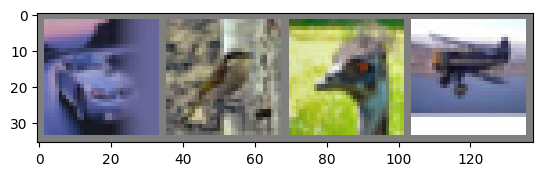

Actual Labels:  car  	bird 	bird 	plane


In [7]:
def imshow(img):
    # Unnormalize pixels
    img = img / 2 + 0.5
    npimg = img.numpy()
    # Put image into shape (32, 32, 3) to display
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random training image batch
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(f'Images data shape: {images.shape}')
print(f'Label raw data: {labels}\n')

# Show images
print("Example of training set batch:")
imshow(utils.make_grid(images))
# Print labels
print('Actual Labels: ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## SimpleCNN Neural Network

The `SimpleCNN` class is a Convolutional Neural Network that is defined in PyTorch. It inherits from the `nn.Module` class.

The `__init__` function for `SimpleCNN`  defines the layers that the network is going to use. The `forward` function defines how to connect the layers, and for a particular input returns the predicted output.

Here is a graphic of what this Convolutional Neural Network looks like. (Notice that the input image shown here is not from CIFAR10).



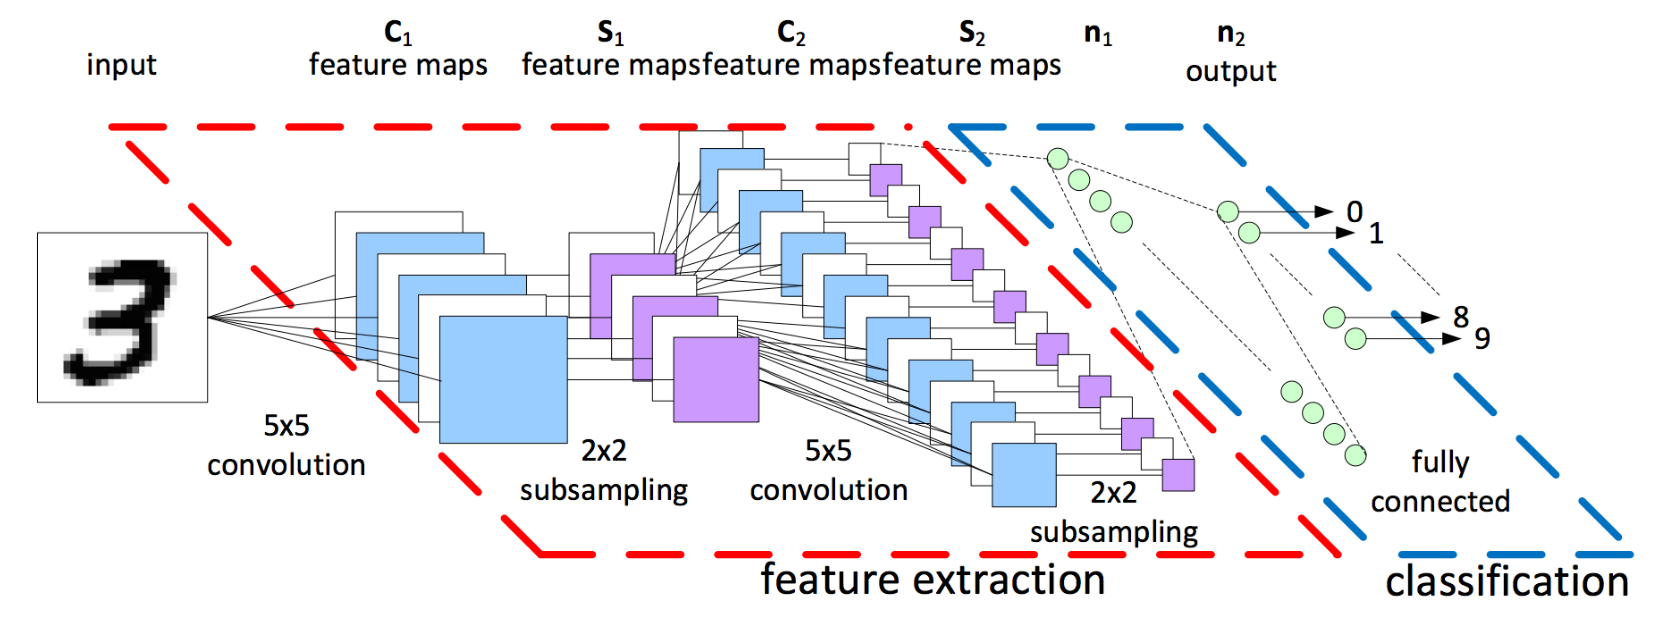

Here is a summary of the layers (from input to output) that this CNN consists of:  
**Layer 1:** Convolutional layer (`self.conv1`)
- Input: 32x32x3 (RGB) image
- Performs convolution with 5 kernels (`out_channels` parameter) of size 5x5
- Output: 28x28x6 convolution output

**Layer 2:** Batch Normalization (`self.bn1`)
- Normalizes the 5 output feature maps from the first convolutional layer to stabilize training

**Layer 3:** Max pooling layer (`self.pool`)
- Input: 28x28x5 output from layer 2
- Subsamples each of the 5 results by taking the max element in 2x2 windows
- Output: 14x14x5 subsampled output

**Layer 4:** Convolutional layer (`self.conv2`)
- Input: 14x14x5 output from layer 3
- Performs convolution with 10 kernels (`out_channels` parameter) of size 5x5
- Output: 10x10x10 convolution output

**Layer 5:** Batch Normalization (`self.bn2`)
- Normalizes the 10 output feature maps from the second convolutional layer to stabilize training

**Layer 6:** Max pooling layer (`self.pool`)
- Input: 10x10x10 output from layer 5
- Output: 5x5x10 subsampled output

**Linear/Fully-connected layers:**
- The diagram above shows 2 fully connected (FC) layers (n1 and n2), but the code contains 3 as described here.
- `self.fc1` takes all 5x5x10 (250) pixels as input nodes and maps them to 120 output nodes
- `self.fc2` takes the 120 nodes as input and maps them to 84 output nodes
- Lastly, `self.fc3` takes the 84 nodes as input and outputs the final 10 nodes corresponding to each class/label for CIFAR10
  

In [8]:
# Don't change the code in this block

class SimpleCNN(nn.Module):
    '''Simple CNN neural network. See above description for what each layer does.'''

    def __init__(self):
        '''Defines each layer for SimpleCNN.'''
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(10)
        self.fc1 = nn.Linear(in_features=10 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        '''Defines graph of connections for each layer in SimpleCNN.'''
        x = self.pool(F.relu(self.bn1(self.conv1(x)))) # Adds Layers 1-3
        x = self.pool(F.relu(self.bn2(self.conv2(x)))) # Adds Layers 4-6
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Loss Function and Gradient Descent

Here is more information about the implementation details. Most of this is background, as far as these Colab problems are concerned.

First, we attempt to use our computer's GPUs if we have any available. On free Google Colab instances, they won't be available, but if you are running this locally with an NVIDIA GPU, you should be able to enable CUDA to run and train the model on your GPU (although this is not necessary).

While this is almost necessary for most larger networks, our network is fairly simple and only takes 32x32 images as input, so training won't take too long on just a CPU.

**Loss Function:** The cross-entropy loss will be our loss function. The loss function is a function we want to minimize. Cross-entropy is a popular loss function for multi-class classification (we have 10 classes).
$$L = -Σ_i(t_i*log(p_i))$$
- The summation is going through each label ($i$) (plane, car, bird, ...).
- $t_i$ is the actual ground truth label we want our model to predict (it is equal to 1 for the true label, 0 for the other 9).
- $p_i$ is the predicted probability for each label from our model.
- Think of all the $p_i$ values as representing a probability distribution. This loss function will approach 0 when the computed distribution is about the same as the given set of $t_i$ values; and this loss function will be high when the computed distribution is wrong.
- More info on cross entropy loss can be found in section 5.1.3 of the textbook and also at this site: https://www.v7labs.com/blog/cross-entropy-loss-guide

**Gradient Descent:** This is the algorithm that updates the weights of our model, based on computing the gradient of $L$ with respect to the weights. We are using SGD (stochastic gradient descent), which  means that we training samples are chosen in random order. (This example will use a batch size of 4 images).
$$𝐖_{t+1} = 𝐖_t - α∇L$$
- 𝐖 is the set of all of the weights in our model, which we are updating by using this equation.
- α is the learning rate. A higher number will update our weight more substantially each iteration, while a lower number will  update them more slowly (`lr = 0.001` in this code).

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"  # Use GPU if possible
print(device)
simple_model = SimpleCNN().to(device)
summary(simple_model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(simple_model.parameters(), lr=0.001, momentum=0.9)

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 28, 28]             380
       BatchNorm2d-2            [-1, 5, 28, 28]              10
         MaxPool2d-3            [-1, 5, 14, 14]               0
            Conv2d-4           [-1, 10, 10, 10]           1,260
       BatchNorm2d-5           [-1, 10, 10, 10]              20
         MaxPool2d-6             [-1, 10, 5, 5]               0
            Linear-7                  [-1, 120]          30,120
            Linear-8                   [-1, 84]          10,164
            Linear-9                   [-1, 10]             850
Total params: 42,804
Trainable params: 42,804
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.09
Params size (MB): 0.16
Estimated Total Size (MB): 0.26
-----------------------------------------

## Training

This is the training loop for the network to actually learn the weights. This loop updates the weights by trying to minimize the loss function, which is eventually computed for all of the training images.

The training loop runs for a defined number of epochs, which is the number of times the model is trained on the entire set of training data (`trainloader`). The data is shuffled between each epoch.

Since we have set everything up, PyTorch does almost everything for us in this step. Here is what it does:

**Steps:**
1. Gets the input images and labels for the current batch (4 images at a time)
2. Gives the model the images, and it will predict the output labels (using the current set of weights)
3. Calculates the loss function between ground truth and predicted labels
4. Calculates all gradients for backpropagation (`loss.backward()`)
5. Performs gradient descent to update the model weights (`optimizer.step()`)
6. Repeats on all images in the training set (50,000 images / 4 per batch = 12,500 iterations)
7. Repeats the above for each epoch

In [10]:
# Don't change the code in this block

def train(model, loader, criterion, optimizer, epochs=2):
  '''Train a model from training data.

  Args:
    - model: Neural network to train
    - epochs: Number of epochs to train the model
    - loader: Dataloader to train the model with
  '''
  print('Start Training')

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      total = 0
      correct = 0
      for i, data in enumerate(tqdm(loader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # print statistics
          running_loss += loss.item()
          if i % 2000 == 1999:    # print every 2000 mini-batches
              print(f'[epoch {epoch + 1}, batch {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

              print(f'\nAccuracy of the network on last 2000 training images: {100 * correct // total} %')
              total = 0
              correct = 0

  print('\nFinished Training')

### This will train our SimpleCNN.

- This will take some time, so be patient.
- It will train the SimpleCNN for 2 epochs, and will print out the average loss and the training accuracy for every 2000 batches.  
- Notice that every 2000 batches, the loss decreases and the training accuracy improves, this is how to tell if a model is correctly learning and improving throughout training.

In [9]:
# Train model on training data from CIFAR10
train(simple_model, trainloader, criterion, optimizer)

Start Training


 16%|█▌        | 2022/12500 [00:17<01:22, 127.33it/s]

[epoch 1, batch  2000] loss: 2.003

Accuracy of the network on last 2000 training images: 24 %


 32%|███▏      | 4017/12500 [00:37<01:06, 127.24it/s]

[epoch 1, batch  4000] loss: 1.715

Accuracy of the network on last 2000 training images: 37 %


 48%|████▊     | 6026/12500 [00:54<00:48, 132.64it/s]

[epoch 1, batch  6000] loss: 1.647

Accuracy of the network on last 2000 training images: 40 %


 64%|██████▍   | 8011/12500 [01:12<00:54, 82.93it/s]

[epoch 1, batch  8000] loss: 1.577

Accuracy of the network on last 2000 training images: 43 %


 80%|████████  | 10006/12500 [01:36<00:48, 51.12it/s]

[epoch 1, batch 10000] loss: 1.539

Accuracy of the network on last 2000 training images: 44 %


 96%|█████████▌| 12025/12500 [02:02<00:03, 128.57it/s]

[epoch 1, batch 12000] loss: 1.484

Accuracy of the network on last 2000 training images: 46 %


 16%|█▌        | 2022/12500 [00:17<01:26, 121.80it/s]

[epoch 2, batch  2000] loss: 1.452

Accuracy of the network on last 2000 training images: 47 %


 32%|███▏      | 4012/12500 [00:35<01:15, 113.03it/s]

[epoch 2, batch  4000] loss: 1.419

Accuracy of the network on last 2000 training images: 48 %


 48%|████▊     | 6013/12500 [00:54<01:25, 76.12it/s]

[epoch 2, batch  6000] loss: 1.413

Accuracy of the network on last 2000 training images: 50 %


 64%|██████▍   | 8023/12500 [01:11<00:33, 134.56it/s]

[epoch 2, batch  8000] loss: 1.405

Accuracy of the network on last 2000 training images: 50 %


 80%|████████  | 10025/12500 [01:29<00:17, 137.71it/s]

[epoch 2, batch 10000] loss: 1.375

Accuracy of the network on last 2000 training images: 51 %


 96%|█████████▌| 12014/12500 [01:46<00:03, 132.51it/s]

[epoch 2, batch 12000] loss: 1.357

Accuracy of the network on last 2000 training images: 51 %


100%|██████████| 12500/12500 [01:50<00:00, 113.18it/s]


Finished Training


## View CNN Prediction

Here is an example of 4 images with their ground truth labels and with the predictions from our CNN model

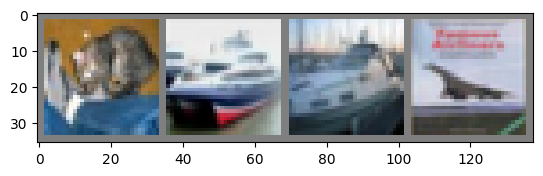

Ground Truth:    cat  	ship 	ship 	plane
CNN prediction:  cat  	plane	ship 	plane


In [10]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images from test set
imshow(utils.make_grid(images))
print('Ground Truth:   ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Input images into model and see ouptut
outputs = simple_model(images)
_, predicted = torch.max(outputs, 1)

print('CNN prediction: ', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

## Testing our SimpleCNN Model

Now we will run our model on the test dataset (`testloader`) from CIFAR10. The model was not trained on this data, so we can measure the accuracy of our model (# correct / total) on this test set. The test dataset contains 10,000 images, which will be 2500 batches for us.

In [11]:
# Don't change the code in this block

def evaluation(model, loader):
  '''Evaluate a model and output its accuracy on a test dataset.

  Args:
    - model: Neural network to evaluate
    - loader: Dataloader containing test dataset
  '''
  # Evaluate accuracy on validation / test set
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in tqdm(loader):
          images, labels = data
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'\nAccuracy of the network on the 10000 test images: {100 * correct // total} %')

### Evaluate SimpleCNN
After running below, you'll see that the accuracy is much better than a random guess (which would be 10% since there are 10 classes), but it is still not perfect. (We got around 50% when running it.)

This example shows the tradeoffs that are made when doing Machine Learning. Our model is simple and the input images are only 32x32x3, so the model trains reasonably fast and does not have many weights, but the accuracy is not amazing because of these choices. Typically, more complex models with more weights require GPUs to run, so this model was kept simple to avoid that need. However, later in this problem you will improve this network and increase the accuracy.

In [12]:
# Evaluate trained model on test dataset
evaluation(simple_model, testloader)

100%|██████████| 2500/2500 [00:13<00:00, 190.74it/s]


Accuracy of the network on the 10000 test images: 53 %


Save trained model so it can be loaded everytime you restart this Notebook, so you don't need to re-train it if you don't want to. Only run the cell below if your model was previously trained.

This step is optional, but useful if you plan to come back to this notebook and want to load your trained model without training it again.

In [14]:
# UNCOMMENT below if you want to save your trained model after training
# (only do this after your model finished training, so you can use it later if desired)
# ------------------------------------------------------------------------------------

# SIMPLECNN_MODEL_PATH = './simplecnn_model.pth'
# torch.save(simple_model.state_dict(), SIMPLECNN_MODEL_PATH)

Load saved model from before. Once again, this is optional.

In [15]:
# UNCOMMENT below if you want to load your saved trained model from before
# (only need to do this if you come back to this notebook and don't want to re-train the model again above)
# ------------------------------------------------------------------------------------
simple_model = SimpleCNN().to(device)
simple_model.load_state_dict(torch.load(SIMPLECNN_MODEL_PATH))

<ipython-input-15-6da1f154152e>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_model.load_state_dict(torch.load(SIMPLECNN_MODEL_PATH))


<All keys matched successfully>

## View SimpleCNN in Action

Run this cell as many times as you want to show a random batch from the test set, the model's predicted class, and the real class

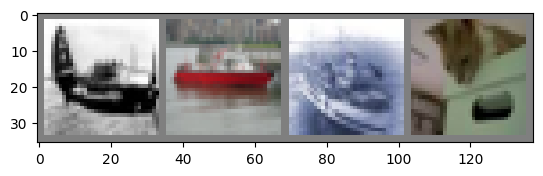

Ground Truth:    plane	ship 	ship 	cat  
CNN prediction:  plane	car  	ship 	deer 


In [16]:
# Random number between 1 and size of test set (9995 + batch_size (4))
random_idx = np.random.randint(9995)

images = []
labels = []
for i in range(random_idx, random_idx + batch_size):
  image, label = testset[i]
  images.append(image)
  labels.append(label)

image_tensors = torch.stack(images)

# print images from test set
imshow(utils.make_grid(image_tensors))
print('Ground Truth:   ', '\t'.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Input images into model and see ouptut
outputs = simple_model(image_tensors)
_, predicted = torch.max(outputs, 1)

print('CNN prediction: ', '\t'.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

# TO DO (Problem 4): Change hyperparameters from the preceeding code

## Create ChangedSimpleCNN

Now that you've gone through a walkthrough of the code above, your goal for this problem is to change the code above to increase the accuracy of the above model to **at least 70%**. You will do this by changing anything about the SimpleCNN network model. Here are some recommendations of parameters to change:
- Add layers (more layers means more parameters to learn)
- Change existing Conv2d layer hyperparameters:
  - Kernel size
  - Padding
  - Number of kernels (out_channels)
    - Increasing the number of kernels used in the Conv2d layer can also give the model more learning possibilities
- Remove or replace any layers (if desired)
- You are welcome to use other built-in PyTorch `nn` layers or activation functions if you are comfortable with them

**Don't** change the `SimpleCNN` model above, instead change the code below, and then re-train and re-evaluate your new network called `ChangedSimpleCNN`

`nn.Conv2d` class API: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

Problem 5 will require you to understand the Conv2d layer in more detail, so if you need more context for this problem, it can be useful to learn about it for that problem and then come back to this one.

In [85]:
import torch.nn as nn

class ChangedSimpleCNN(nn.Module):
    '''Modified CNN to achieve expected accuracy.'''
    def __init__(self):
        super().__init__()
        # First convolutional layer: in_channels=3 (RGB), out_channels=8, kernel_size=5
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(8)  # Batch normalization
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second convolutional layer: in_channels=8, out_channels=16, kernel_size=3
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        # Third convolutional layer: in_channels=16, out_channels=32, kernel_size=3
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 4 * 4, 120)  # Adjust input features based on output size after pooling
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 output classes

    def forward(self, x):
        # First Conv2D -> ReLU -> Pool
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        # Second Conv2D -> ReLU -> Pool
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        # Third Conv2D -> ReLU -> Pool
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))

        # Flatten the feature map
        x = x.view(-1, 32 * 4 * 4)  # Adjust based on the final pooled output size
        # Fully connected layers
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = self.fc3(x)  # No activation for the final layer (CrossEntropyLoss expects logits)
        return x

### You may also change the marked hyperparameters below, including:
- Learning rate (`lr` parameter in the `optimizer`)
  - Lower number means more gradual steps, higher number means faster, larger steps
- Epochs (`epochs` variable)
  - This is the number of times the model is trained on the training data (shuffled).
  - Higher number means more training time but will take longer
  - Keep number of epochs to 10 or below

In [86]:
import torch.optim as optim

# Define the model, loss function, and optimizer
changed_model = ChangedSimpleCNN().to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (adjust learning rate if needed)
optimizer = optim.SGD(changed_model.parameters(), lr=0.001, momentum=0.9)  # Slightly higher learning rate

### Train ChangedSimpleCNN

In [87]:
# Can change number of epochs, but keep it at 10 or below
epochs = 10
train(changed_model, trainloader, criterion, optimizer, epochs=epochs)

Start Training


 16%|█▌        | 2022/12500 [00:22<01:40, 104.08it/s]

[epoch 1, batch  2000] loss: 1.860

Accuracy of the network on last 2000 training images: 31 %


 32%|███▏      | 4013/12500 [00:47<01:16, 111.04it/s]

[epoch 1, batch  4000] loss: 1.570

Accuracy of the network on last 2000 training images: 42 %


 48%|████▊     | 6011/12500 [01:08<01:32, 70.11it/s]

[epoch 1, batch  6000] loss: 1.451

Accuracy of the network on last 2000 training images: 47 %


 64%|██████▍   | 8012/12500 [01:29<00:40, 111.28it/s]

[epoch 1, batch  8000] loss: 1.380

Accuracy of the network on last 2000 training images: 50 %


 80%|████████  | 10018/12500 [01:50<00:22, 112.03it/s]

[epoch 1, batch 10000] loss: 1.312

Accuracy of the network on last 2000 training images: 52 %


 96%|█████████▌| 12017/12500 [02:10<00:04, 110.43it/s]

[epoch 1, batch 12000] loss: 1.279

Accuracy of the network on last 2000 training images: 53 %


 16%|█▌        | 2013/12500 [00:20<01:34, 110.62it/s]

[epoch 2, batch  2000] loss: 1.182

Accuracy of the network on last 2000 training images: 57 %


 32%|███▏      | 4022/12500 [00:41<01:19, 106.64it/s]

[epoch 2, batch  4000] loss: 1.156

Accuracy of the network on last 2000 training images: 59 %


 48%|████▊     | 6014/12500 [01:02<01:29, 72.85it/s]

[epoch 2, batch  6000] loss: 1.148

Accuracy of the network on last 2000 training images: 59 %


 64%|██████▍   | 8021/12500 [01:27<00:41, 107.31it/s]

[epoch 2, batch  8000] loss: 1.115

Accuracy of the network on last 2000 training images: 60 %


 80%|████████  | 10016/12500 [01:48<00:23, 107.56it/s]

[epoch 2, batch 10000] loss: 1.097

Accuracy of the network on last 2000 training images: 60 %


 96%|█████████▌| 12009/12500 [02:08<00:06, 79.31it/s]

[epoch 2, batch 12000] loss: 1.095

Accuracy of the network on last 2000 training images: 61 %


 16%|█▌        | 2013/12500 [00:20<01:34, 110.52it/s]

[epoch 3, batch  2000] loss: 1.003

Accuracy of the network on last 2000 training images: 64 %


 32%|███▏      | 4017/12500 [00:41<01:20, 105.79it/s]

[epoch 3, batch  4000] loss: 1.016

Accuracy of the network on last 2000 training images: 64 %


 48%|████▊     | 6018/12500 [01:03<01:16, 85.27it/s]

[epoch 3, batch  6000] loss: 0.977

Accuracy of the network on last 2000 training images: 65 %


 64%|██████▍   | 8011/12500 [01:25<00:40, 111.18it/s]

[epoch 3, batch  8000] loss: 0.989

Accuracy of the network on last 2000 training images: 65 %


 80%|████████  | 10021/12500 [01:45<00:21, 112.86it/s]

[epoch 3, batch 10000] loss: 0.980

Accuracy of the network on last 2000 training images: 65 %


 96%|█████████▌| 12015/12500 [02:06<00:04, 97.72it/s] 

[epoch 3, batch 12000] loss: 0.976

Accuracy of the network on last 2000 training images: 65 %


 16%|█▌        | 2021/12500 [00:20<01:31, 114.04it/s]

[epoch 4, batch  2000] loss: 0.896

Accuracy of the network on last 2000 training images: 68 %


 32%|███▏      | 4019/12500 [00:41<01:18, 107.83it/s]

[epoch 4, batch  4000] loss: 0.910

Accuracy of the network on last 2000 training images: 68 %


 48%|████▊     | 6018/12500 [01:05<00:56, 114.82it/s]

[epoch 4, batch  6000] loss: 0.912

Accuracy of the network on last 2000 training images: 67 %


 64%|██████▍   | 8011/12500 [01:27<01:09, 64.91it/s]

[epoch 4, batch  8000] loss: 0.910

Accuracy of the network on last 2000 training images: 67 %


 80%|████████  | 10022/12500 [01:49<00:22, 109.74it/s]

[epoch 4, batch 10000] loss: 0.900

Accuracy of the network on last 2000 training images: 68 %


 96%|█████████▌| 12017/12500 [02:09<00:04, 107.54it/s]

[epoch 4, batch 12000] loss: 0.886

Accuracy of the network on last 2000 training images: 69 %


 16%|█▌        | 2016/12500 [00:22<01:42, 102.32it/s]

[epoch 5, batch  2000] loss: 0.818

Accuracy of the network on last 2000 training images: 70 %


 32%|███▏      | 4011/12500 [00:43<01:20, 105.49it/s]

[epoch 5, batch  4000] loss: 0.847

Accuracy of the network on last 2000 training images: 69 %


 48%|████▊     | 6022/12500 [01:04<00:58, 109.97it/s]

[epoch 5, batch  6000] loss: 0.843

Accuracy of the network on last 2000 training images: 70 %


 64%|██████▍   | 8006/12500 [01:26<01:10, 64.16it/s]

[epoch 5, batch  8000] loss: 0.835

Accuracy of the network on last 2000 training images: 70 %


 80%|████████  | 10017/12500 [01:47<00:21, 114.13it/s]

[epoch 5, batch 10000] loss: 0.850

Accuracy of the network on last 2000 training images: 70 %


 96%|█████████▌| 12012/12500 [02:08<00:04, 110.41it/s]

[epoch 5, batch 12000] loss: 0.820

Accuracy of the network on last 2000 training images: 71 %


 16%|█▌        | 2012/12500 [00:25<01:37, 107.23it/s]

[epoch 6, batch  2000] loss: 0.779

Accuracy of the network on last 2000 training images: 72 %


 32%|███▏      | 4017/12500 [00:46<01:18, 107.50it/s]

[epoch 6, batch  4000] loss: 0.786

Accuracy of the network on last 2000 training images: 72 %


 48%|████▊     | 6010/12500 [01:06<01:00, 106.87it/s]

[epoch 6, batch  6000] loss: 0.792

Accuracy of the network on last 2000 training images: 72 %


 64%|██████▍   | 8009/12500 [01:29<01:07, 66.71it/s]

[epoch 6, batch  8000] loss: 0.784

Accuracy of the network on last 2000 training images: 72 %


 80%|████████  | 10013/12500 [01:50<00:22, 113.02it/s]

[epoch 6, batch 10000] loss: 0.786

Accuracy of the network on last 2000 training images: 72 %


 96%|█████████▌| 12014/12500 [02:10<00:04, 114.81it/s]

[epoch 6, batch 12000] loss: 0.787

Accuracy of the network on last 2000 training images: 72 %


 16%|█▌        | 2014/12500 [00:22<01:39, 105.21it/s]

[epoch 7, batch  2000] loss: 0.716

Accuracy of the network on last 2000 training images: 74 %


 32%|███▏      | 4013/12500 [00:43<01:19, 107.04it/s]

[epoch 7, batch  4000] loss: 0.723

Accuracy of the network on last 2000 training images: 74 %


 48%|████▊     | 6012/12500 [01:03<00:59, 108.48it/s]

[epoch 7, batch  6000] loss: 0.760

Accuracy of the network on last 2000 training images: 73 %


 64%|██████▍   | 8009/12500 [01:26<01:08, 65.39it/s]

[epoch 7, batch  8000] loss: 0.739

Accuracy of the network on last 2000 training images: 73 %


 80%|████████  | 10019/12500 [01:47<00:22, 109.98it/s]

[epoch 7, batch 10000] loss: 0.756

Accuracy of the network on last 2000 training images: 73 %


 96%|█████████▌| 12012/12500 [02:10<00:04, 113.18it/s]

[epoch 7, batch 12000] loss: 0.762

Accuracy of the network on last 2000 training images: 73 %


 16%|█▌        | 2014/12500 [00:22<01:30, 115.80it/s]

[epoch 8, batch  2000] loss: 0.684

Accuracy of the network on last 2000 training images: 75 %


 32%|███▏      | 4020/12500 [00:42<01:15, 112.81it/s]

[epoch 8, batch  4000] loss: 0.696

Accuracy of the network on last 2000 training images: 75 %


 48%|████▊     | 6012/12500 [01:02<00:55, 116.77it/s]

[epoch 8, batch  6000] loss: 0.703

Accuracy of the network on last 2000 training images: 74 %


 64%|██████▍   | 8008/12500 [01:24<01:09, 64.54it/s]

[epoch 8, batch  8000] loss: 0.725

Accuracy of the network on last 2000 training images: 74 %


 80%|████████  | 10017/12500 [01:45<00:22, 112.06it/s]

[epoch 8, batch 10000] loss: 0.713

Accuracy of the network on last 2000 training images: 74 %


 96%|█████████▌| 12012/12500 [02:05<00:04, 115.58it/s]

[epoch 8, batch 12000] loss: 0.717

Accuracy of the network on last 2000 training images: 74 %


 16%|█▌        | 2018/12500 [00:22<01:35, 110.23it/s]

[epoch 9, batch  2000] loss: 0.642

Accuracy of the network on last 2000 training images: 77 %


 32%|███▏      | 4024/12500 [00:42<01:13, 115.64it/s]

[epoch 9, batch  4000] loss: 0.654

Accuracy of the network on last 2000 training images: 76 %


 48%|████▊     | 6017/12500 [01:03<00:59, 109.29it/s]

[epoch 9, batch  6000] loss: 0.673

Accuracy of the network on last 2000 training images: 76 %


 64%|██████▍   | 8014/12500 [01:28<00:59, 75.26it/s]

[epoch 9, batch  8000] loss: 0.677

Accuracy of the network on last 2000 training images: 76 %


 80%|████████  | 10023/12500 [01:49<00:21, 115.66it/s]

[epoch 9, batch 10000] loss: 0.691

Accuracy of the network on last 2000 training images: 75 %


 96%|█████████▌| 12012/12500 [02:09<00:04, 111.30it/s]

[epoch 9, batch 12000] loss: 0.683

Accuracy of the network on last 2000 training images: 76 %


 16%|█▌        | 2018/12500 [00:22<01:34, 110.34it/s]

[epoch 10, batch  2000] loss: 0.621

Accuracy of the network on last 2000 training images: 78 %


 32%|███▏      | 4017/12500 [00:42<01:14, 113.55it/s]

[epoch 10, batch  4000] loss: 0.622

Accuracy of the network on last 2000 training images: 78 %


 48%|████▊     | 6019/12500 [01:03<00:59, 109.33it/s]

[epoch 10, batch  6000] loss: 0.650

Accuracy of the network on last 2000 training images: 77 %


 64%|██████▍   | 8011/12500 [01:24<01:01, 72.67it/s]

[epoch 10, batch  8000] loss: 0.641

Accuracy of the network on last 2000 training images: 77 %


 80%|████████  | 10022/12500 [01:46<00:22, 110.35it/s]

[epoch 10, batch 10000] loss: 0.654

Accuracy of the network on last 2000 training images: 76 %


 96%|█████████▌| 12018/12500 [02:06<00:04, 111.43it/s]

[epoch 10, batch 12000] loss: 0.668

Accuracy of the network on last 2000 training images: 76 %


100%|██████████| 12500/12500 [02:10<00:00, 95.49it/s]


Finished Training


### Evaluate ChangedSimpleCNN

In [88]:
# Try to achieve accuracy >=70% for this problem on the test set
evaluation(changed_model, testloader)

100%|██████████| 2500/2500 [00:16<00:00, 154.33it/s]


Accuracy of the network on the 10000 test images: 71 %


# Problem 5: Implement Convolutional Layer Yourself

## Implement Custom Conv2d Layer

In the previous problem, we used PyTorch's built-in `nn.Conv2d` layer, which is called the Convolutional Layer (Conv2d layer), and is the backbone of a CNN.

In this problem, you will make the Conv2d layer yourself.

###**Conv2d Quick Overview:**
- In short, the Conv2d layer performs convolution as you have learned in this course, but with several sets of kernels.
- As we train the network, it will learn what values to use in each kernel to  classify the images with better accuracy.
- Thus, the network essentially learns which filters work best (such as edge detectors) instead of us having to hand-pick them.



In order to implement the Conv2d layer yourself, you will need to understand how this layer works in-depth, and familiarize yourself with the size of the inputs and outputs of the layer.

For an in-depth breakdown of CNNs, see section 5.4 of the textbook, or skip to the Convolutional Layer section at this site: https://cs231n.github.io/convolutional-networks/
  - This resource mentions padding ($P$) and stride ($S$), but we will simplify our layer and not worry about these parameters.


To simplify parts of it, your Conv2d layer will only use stride 1 ($S=1$, normal convolution) and no padding ($P=0$).

###**Conv2d Breakdown:**
**Note:** *The rest of this notebook uses this notation, so you will most likely reference this a lot.*
- Input (shape $B*N*H_1*W_1$):
  - $B$: Batch size (number of images in this input)
  - $N$: Number of channels (depth) in input
  - $W_1$: Width of input image
  - $H_1$: Height of input image
- Kernels:
  - $F$: Kernel size, such that kernel width and height is $F*F$
- Output (shape $B*D*H_2*W_2$):
  - $B$: Batch size (need an output for each image in the batch)
  - $D$: Number of channels (depth) for output
    - This is equal to the number of kernels that will be convoled with the inputs
  - $W_2 = (W_1 - F) + 1$
    - Width of output image
  - Since we have square images, $H_2 = W_2$

### In the code below, you will implement the `forward` function for a Conv2d layer.

Read how Conv2d layer does forward pass: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

Forward pass for convolutional layer:
\begin{equation}
Y_i = B_i + \sum_{j=1}^{N}{X_j}\star{K_{ij}} \\
for \space i = 1...\space{D}
\end{equation}

In above equation:
- $Y_i$: Output image at output depth $i$
- $X_i$: Input image at input depth $j$
- $K_{ij}$: Kernel for output depth $i$ and input depth $j$
- $B_i$: Bias for output depth $i$
- $\star$ operator: Valid cross-correlation
  - See 'valid' mode: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html

**Hints:**
- You are allowed use cross-correlation library functions such as `scipy.signal.correlate2d`, which are optimized, instead of doing it by hand, but do NOT use any PyTorch built-in convolution functions, such as Conv2d. If you implement the convolutions by hand, we recommend not to use loops as the training time will take too long.
- It can be useful to look at the cell after this to see what inputs will be given to this function for testing.  
- Your implementation here will heavily determine the **speed** of training this model. If you want to implement convolution by hand it can be done with linear algebra techniques to vectorize and use no loops in this function, which is ideal but can be tricky (this is not required). Our `forward` implementation did use some for loops, and the model took about 1 hour to fully train.
- You will be working with PyTorch tensors to implement this problem. Treat these as you treat NumPy ndarray, as they are largely the same with the same functions
  - For example, to create a PyTorch tensor of all zeros with shape (2, 2, 3):
    `torch.zeros(2, 2, 3)`
- For functions that output NumPy arrays, you can use `torch.from_numpy(...)` to convert it to a PyTorch tensor.

In [36]:
from scipy.signal import correlate2d
import torch

class MyConv2dForward(torch.autograd.Function):
    '''Custom Conv2D Layer Forward Pass'''

    # Class variables to store tensors
    saved_x = None
    saved_kernels = None
    saved_bias = None

    @staticmethod
    def forward(x, kernels, bias):
        '''
        Forward pass of convolutional layer.

        Args:
          x: Input tensor of shape (B, N, H1, W1)
          kernels: Kernels of shape (F, F, N, D) - Transposed format
          bias: Bias of shape (D, H2, W2)

        Returns:
          Tensor of shape (B, D, H2, W2)
        '''

        B, N, H1, W1 = x.shape  # Input dimensions
        F, _, _, D = kernels.shape  # Kernel dimensions

        # Compute output height and width
        H2, W2 = H1 - F + 1, W1 - F + 1

        # Initialize output tensor
        output = torch.zeros((B, D, H2, W2), dtype=x.dtype, device=x.device)

        # Perform convolution
        for b in range(B):  # Loop over batch
            for d in range(D):  # Loop over output channels
                output_channel = torch.zeros((H2, W2), dtype=x.dtype, device=x.device)
                for n in range(N):  # Loop over input channels
                    # Perform valid cross-correlation
                    # print(x[b,n].shape)
                    # print(kernels[:, :, n, d].shape)
                    output_channel += torch.tensor(
                        correlate2d(
                            x[b, n].cpu().numpy(),  # Convert to NumPy
                            kernels[:, :, n, d].cpu().numpy(),  # Kernel
                            mode='valid'
                        ),
                        device=x.device
                    )
                # Add bias for this output channel
                output[b, d, :, :] = output_channel + bias[d]

        # # Save tensors as class variables
        # MyConv2dForward.saved_x = x
        # MyConv2dForward.saved_kernels = kernels
        # MyConv2dForward.saved_bias = bias

        return output


### Test your Conv2d `forward` pass:

In [37]:
# Get random training image batch
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'Input shape: {images.shape}')

# Sanity check of convolutional layer
kernels = torch.randn(5, 5, 3, 6)
bias = torch.randn(6, 28, 28)
out = MyConv2dForward.forward(images, kernels, bias)
print(f'Output shape: {out.shape}')

# CHECK: Output shape should be [4, 6, 28, 28]

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 6, 28, 28])


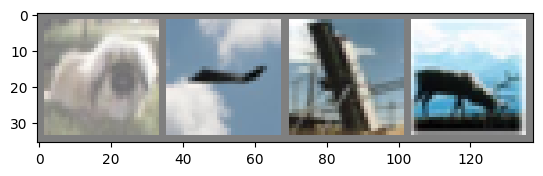

Images after filtering:


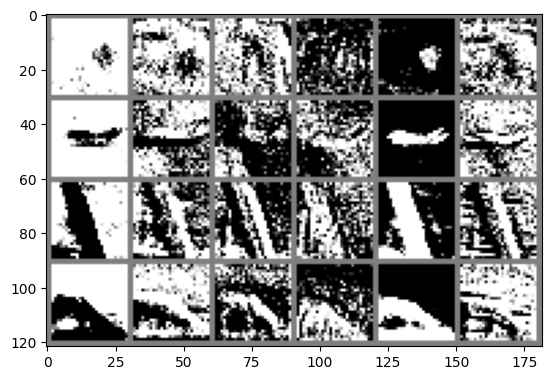

In [38]:
imshow(utils.make_grid(images))

# Visualize output images after filtering (in grayscale)
print('Images after filtering:')
out = out.reshape(out.shape[0]*out.shape[1], 1, out.shape[2], out.shape[3])
imshow(utils.make_grid(out, nrow=6))

# CHECK: The images after filtering should look as such if correct:
#   - Each row corresponds to a different image
#   - Each column is that image filtered with a different kernel

### In the code below, you will now implement the `backward` function for your Conv2d layer

To implement backpropagation for a neural network, the network needs the gradient of the loss function with respect to each input passed to the `forward` function. In the case of the Conv2d layer, we will be calculating this gradient for the kernels, input images, and bias.

Loss gradients you need to find with respect to each input variable:

\begin{equation}
\frac{\partial{L}}{\partial{X_i}}, \frac{\partial{L}}{\partial{B_i}}, \frac{\partial{L}}{\partial{K_{ij}}} \\
\text{known: }
\frac{\partial{L}}{\partial{Y_i}}
\end{equation}

In the above partial derivatives:
- $L$: loss function (error)
- $Y_i$: Output image from forward pass
- $X_i$: Input image to layer
- $B_i$: Bias parameters
- $K_{ij}$: Kernel parameters

The derivative of the loss function with respect to the output image ($Y_i$) is given by PyTorch as an input parameter to `backward` called `grad_output`, so we don't need to worry about finding this, treat it as an input.
- `grad_output` has shape ($B * D * H_2 * W_2$)

It is possible to derive these backpropagation partial derivatives (gradients) using the forward pass equation. The derivations are shown here (optional read): https://deeplearning.cs.cmu.edu/F21/document/recitation/Recitation5/CNN_Backprop_Recitation_5_F21.pdf

You will use these equations to calculate the gradients:
1. Gradient w.r.t. input image:
\begin{equation}
\frac{\partial{L}}{\partial{X_j}} = \sum_{i=1}^{D}\frac{\partial{L}}{\partial{Y_i}}*K_{ij} \\
for \space j = 1...\space{N}
\end{equation}
  - $*$ operator: Full convolution
    - see 'full' mode: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

2. Gradient w.r.t. kernel
\begin{equation}
\frac{\partial{L}}{\partial{K_{ij}}} = X_j \star \frac{\partial{L}}{\partial{Y_i}} \\
for \space i = 1...\space{D}, \space j = 1...\space{N}
\end{equation}
  - $\star$ operator: Valid cross-correlation (see link in `forward` section)

3. Gradient w.r.t. bias
\begin{equation}
\frac{\partial{L}}{\partial{B_i}} = \frac{\partial{L}}{\partial{Y_i}} \\
for \space i = 1...\space{D}
\end{equation}

**Hints:**
- You can use library functions to perform convolution and cross-correlation, such as `scipy.signal.correlate2d` and `scipy.signal.convolve2d`

In [43]:
def cross_correlate2d(input, kernel):
    '''Perform cross-correlation between two 2D tensors.'''
    H_in, W_in = input.shape
    H_k, W_k = kernel.shape
    H_out = H_in - H_k + 1
    W_out = W_in - W_k + 1
    output = torch.zeros((H_out, W_out), device=input.device)
    for i in range(H_out):
        for j in range(W_out):
            region = input[i:i+H_k, j:j+W_k]
            output[i, j] = (region * kernel).sum()
    return output


In [70]:
import torch
from scipy.signal import correlate2d
import numpy as np

class MyConv2d(MyConv2dForward):
    '''Full custom Conv2d functions with backpropagation using correlate2d.'''

    @staticmethod
    def setup_context(ctx, inputs, output):
        '''Save tensors for backward. Don't change this function.'''
        x, kernels, bias = inputs
        ctx.save_for_backward(x, kernels, bias)

    @staticmethod
    def backward(ctx, grad_output):
        '''
          Backward pass for the convolutional layer using correlate2d.

          Args:
            grad_output: Gradient of the loss w.r.t. the output Y, shape (B, D, H_out, W_out)

          Returns:
            - Gradient w.r.t. input X (B, N, H_in, W_in)
            - Gradient w.r.t. kernels K (F, F, N, D)
            - Gradient w.r.t. bias B (D,)
        '''
        # Retrieve saved tensors from forward pass
        x, kernels, bias = ctx.saved_tensors

        B, N, H_in, W_in = x.shape             # Input dimensions
        F_h, F_w, N_k, D = kernels.shape       # Kernel dimensions (F, F, N, D)
        _, _, H_out, W_out = grad_output.shape # Output dimensions

        # Ensure kernel dimensions match
        assert N == N_k, "Number of input channels in x and kernels must match"

        # Compute gradient w.r.t. bias (D,)
        grad_bias = grad_output.clone()  # Sum over batch, height, width

        # Initialize gradients
        grad_kernels = torch.zeros_like(kernels)  # Shape: (F_h, F_w, N, D)
        grad_x = torch.zeros_like(x)              # Shape: (B, N, H_in, W_in)

        # Compute gradient w.r.t. kernels
        for n in range(N):
            for d in range(D):
                grad_kernel_nd = torch.zeros((F_h, F_w), device=x.device)
                for b in range(B):
                    # Get x[b, n] and grad_output[b, d]
                    x_bn = x[b, n].detach().cpu().numpy()
                    grad_output_bd = grad_output[b, d].detach().cpu().numpy()

                    # Ensure arrays are contiguous
                    x_bn = np.ascontiguousarray(x_bn)
                    grad_output_bd = np.ascontiguousarray(grad_output_bd)

                    # Cross-correlation between x[b, n] and grad_output[b, d]
                    corr = correlate2d(x_bn, grad_output_bd, mode='valid')

                    # Accumulate gradient
                    grad_kernel_nd += torch.tensor(corr, device=x.device)

                # Assign computed gradient to grad_kernels
                grad_kernels[:, :, n, d] = grad_kernel_nd

        # Compute gradient w.r.t. input
        for b in range(B):
            for n in range(N):
                grad_x_bn = torch.zeros((H_in, W_in), device=x.device)
                for d in range(D):
                    # Get grad_output[b, d] and kernels[:, :, n, d]
                    grad_output_bd = grad_output[b, d].detach().cpu().numpy()
                    kernel_nd = kernels[:, :, n, d].detach().cpu().numpy()

                    # Ensure arrays are contiguous
                    grad_output_bd = np.ascontiguousarray(grad_output_bd)
                    kernel_nd = np.ascontiguousarray(kernel_nd)

                    # Flip kernel for convolution
                    kernel_flipped = np.flip(np.flip(kernel_nd, axis=0), axis=1)

                    # Convolution (full mode)
                    conv = correlate2d(grad_output_bd, kernel_flipped, mode='full')

                    # Accumulate gradient
                    grad_x_bn += torch.tensor(conv, device=x.device)

                # Assign computed gradient to grad_x
                grad_x[b, n] = grad_x_bn

        return grad_x, grad_kernels, grad_bias


### Test `backward` function
- PyTorch has a function called `gradcheck` which will numerically check if your `backward` function has the correct gradient for your `forward` function.
- If done correctly, this cell should output `True`

In [71]:
# Check that gradients calculated in `backward` are correct
images.requires_grad = True
kernels.requires_grad = True
bias.requires_grad = True
image = images[0, 0, :16, :16]

bias = torch.randn(2, 15, 15)
kernels = torch.randn(2, 2, 1, 2)

test = torch.autograd.gradcheck(MyConv2d.apply, (image.reshape(1, 1, 16, 16), kernels, bias), eps=1e-3, atol=1e-2)
print(test)
# CHECK: should output True if forward and backward passes are correct

/usr/local/lib/python3.10/dist-packages/torch/autograd/gradcheck.py:919: UserWarning: Input #0 requires gradient and is not a double precision floating point or complex. This check will likely fail if all the inputs are not of double precision floating point or complex. 
  warnings.warn(


True


### In the code below, you will now implement the actual Conv2d custom layer.
- This `MyConv2dLayer` class will use the `MyConv2d` foward and backward functions you implemented above.
- In the constructor of this class, you will initialize the kernels and biases as the model parameters.

We will initialize our parameters the same way that the PyTorch `nn.Conv2d` layer does.
See the 'Variables:' section at the bottom for information: https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html#torch.nn.Conv2d

From the above reference,
- Initialize the kernels with a Uniform Distribution (look into `np.random.uniform`) where the bounds are $(-\sqrt{k}, \sqrt{k})$.
  - where $k = \frac{1}{N*F*F}$

**Hints:**
- Since we want the kernels and biases to be learnable parameters for the model, they should be set as such:  
  - `self.kernels = nn.Parameter(...)`
  - `self.bias = nn.Parameter(...)`
- You are welcome to change the parameters to this `MyConv2dLayer` or which ones you use if you please. Just note you will have to change them in following code sections if you do.

In [72]:
import torch
import torch.nn as nn
import numpy as np

class MyConv2dLayer(nn.Module):
    '''Custom Conv2d Layer, which calls MyConv2d in forward function with defined parameters to learn.'''

    def __init__(self, in_channels, out_channels, kernel_size, image_size):
        '''
        Args:
          - in_channels: Depth of input tensor (N)
          - out_channels: Depth of output tensor (number of kernels for convolution) (D)
          - kernel_size: Size of kernels (width and height) (F)
          - image_size: Shape of input images to this layer (H1, W1)
            - For example, 32x32 images would be (32, 32)

        Should define self.kernels and self.bias parameters
        '''
        super().__init__()

        N = in_channels   # Number of input channels (N)
        D = out_channels  # Number of output channels (D)
        F = kernel_size   # Kernel size (F)
        H1, W1 = image_size  # Input image dimensions (H1, W1)

        # Compute k for initialization bounds
        k = 1 / (N * F * F)
        bound = k**0.5

        # Initialize kernels with Uniform(-sqrt(k), sqrt(k))
        # Kernels shape: (F, F, N, D) to match testing code
        kernels = np.random.uniform(-bound, bound, size=(F, F, N, D))
        self.kernels = nn.Parameter(torch.tensor(kernels, dtype=torch.float32))

        # Calculate output dimensions
        H2 = H1 - F + 1
        W2 = W1 - F + 1

        # Initialize bias with zeros
        # Bias shape: (D, H2, W2)
        bias = np.zeros((D, H2, W2), dtype=np.float32)
        self.bias = nn.Parameter(torch.tensor(bias))

    def forward(self, x):
        '''Forward for layer.

        Args:
          - x: Input to layer

        Output:
          - Output from layer after forward pass to pass to next layer
        '''
        # Do not make changes to this function
        return MyConv2d.apply(x, self.kernels, self.bias)


### Test MyConv2dLayer

In [73]:
# Test convolutional layer with N=3, D=6, F=5, with 32x32 input images
ConvTest = MyConv2dLayer(in_channels=3, out_channels=6, kernel_size=5, image_size=(32, 32))

# Get random training image batch
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(f'Input shape: {images.shape}')

# Sanity check of convolutional layer
out = ConvTest(images)
kernels = torch.randn(5, 5, 3, 6)
print(f'Output shape: {out.shape}')

# CHECK: Output shape should be [4, 6, 28, 28]

Input shape: torch.Size([4, 3, 32, 32])
Output shape: torch.Size([4, 6, 28, 28])


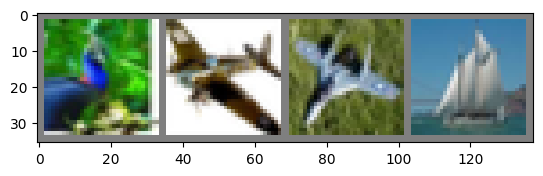

Images after filtering:


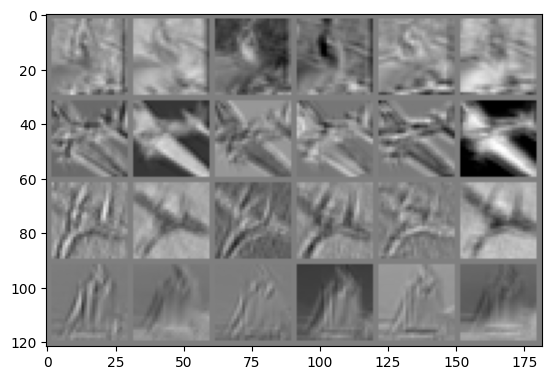

In [74]:
imshow(utils.make_grid(images))

# Visualize output images after filtering (in grayscale)
print('Images after filtering:')
out = out.reshape(out.shape[0]*out.shape[1], 1, out.shape[2], out.shape[3])
imshow(utils.make_grid(out, nrow=6))

# CHECK: The images after filtering should look as such if correct
#   - Each row corresponds to a different image
#   - Each column is that image filtered with a different kernel

PyTorch keeps a dictionary of all parameters that will be learned for the layer, so this code makes sure that your `kernels` and `bias` tensors were registered as model parameters.

In [75]:
print([p for p in ConvTest.named_parameters()])
# Ensure that 'kernels' and 'bias' are listed as parameters for this layer

[('kernels', Parameter containing:
tensor([[[[ 4.5675e-02, -1.5264e-02,  1.5357e-02,  1.0899e-01, -4.4676e-02,
           -1.1505e-01],
          [ 9.8945e-02,  7.8870e-02,  1.0716e-01, -7.2718e-03,  1.1075e-01,
            5.5032e-02],
          [-8.8739e-02, -7.6816e-03,  8.9168e-02,  2.7312e-02, -1.5267e-02,
            5.4503e-02]],

         [[-6.1515e-02, -6.2601e-02,  1.0385e-01,  1.0389e-01, -1.0080e-01,
           -6.7147e-02],
          [-7.4417e-02,  9.2636e-02,  5.0129e-02, -1.0079e-01,  7.8880e-02,
           -9.8553e-02],
          [-7.5369e-02,  1.1624e-02,  8.8545e-02, -8.1087e-02, -4.0715e-02,
            1.0900e-01]],

         [[ 1.0022e-01, -8.1434e-02,  1.1630e-02,  9.5542e-02, -5.7935e-02,
            1.1198e-01],
          [ 7.8259e-02,  1.1511e-01, -6.2152e-02,  7.4918e-03, -1.6783e-02,
           -7.8539e-02],
          [-7.2172e-03, -3.6555e-02, -1.1545e-01, -1.0299e-01, -1.5265e-02,
           -5.2667e-02]],

         [[ 9.1261e-02, -6.9314e-02, -3.2289e-02, 

## Training your CustomSimpleCNN network
- Now, your `MyConv2dLayer` can replace PyTorch's `nn.Conv2d` layer in the `SimpleCNN` network, which is done for you below
- We will train this network, and should see similar accuracy results for the trained `SimpleCNN` architecture

In [76]:
# No need to change anything here, unless you changed your MyConv2dLayer constructor parameters

class CustomSimpleCNN(nn.Module):
    '''CustomSimpleCNN uses your own custom Conv2d layer from this problem.'''

    def __init__(self):
        '''Defines layers for this network.'''
        super().__init__()

        self.conv1 = MyConv2dLayer(in_channels=3, out_channels=6, kernel_size=5, image_size=(32, 32))
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = MyConv2dLayer(in_channels=6, out_channels=16, kernel_size=5, image_size=(14, 14))
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        '''Defines graph connections for layers of this network.'''

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [77]:
custom_model = CustomSimpleCNN().to(device)
summary(custom_model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
     MyConv2dLayer-1            [-1, 6, 28, 28]           4,704
         MaxPool2d-2            [-1, 6, 14, 14]               0
     MyConv2dLayer-3           [-1, 16, 10, 10]           1,600
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 65,438
Trainable params: 59,134
Non-trainable params: 6,304
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.25
Estimated Total Size (MB): 0.32
----------------------------------------------------------------


### Optional Debug Loop
- The code below is commented out and not necessary to run, but will run training for 3 batches and allow you to print out some sample gradients being calculated for your model parameters (kernels and bias).
  - To verify the gradients, ensure that they are valid and change between loop iterations.
- You can uncomment this and use it to print anything during training to help debug your model if necessary.

In [78]:
# UNCOMMENT if wanting to debug anything for a couple training iterations

print('Training Debug Loop')

for i, data in enumerate(tqdm(trainloader)):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = custom_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    if i == 3:
      break

    print('\n')
    print(f'---------------------------------{i}---------------------------------')
    print('KERNEL GRADIENTS:\n')
    print(custom_model.conv1.kernels.grad[0, 0, :, :])
    print('BIAS GRADIENTS:\n')
    print(custom_model.conv1.bias.grad[0, :5, :5])

Training Debug Loop


  0%|          | 2/12500 [00:00<34:17,  6.07it/s]



---------------------------------0---------------------------------
KERNEL GRADIENTS:

tensor([[-4.6651e-04,  3.7452e-03, -1.4526e-03, -2.1687e-03, -2.6479e-03,
          1.2841e-03],
        [-9.4895e-04,  3.4012e-03, -2.5011e-03, -1.9863e-03, -1.9478e-03,
          1.6409e-03],
        [-8.6551e-05,  3.7444e-03, -2.3535e-03, -2.0923e-03, -1.7229e-03,
          2.4566e-03]])
BIAS GRADIENTS:

tensor([[-2.7747e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  6.3805e-05,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  4.3916e-05],
        [ 2.8709e-05, -9.3602e-07,  0.0000e+00,  7.2705e-05, -2.0059e-04],
        [ 0.0000e+00, -2.6322e-05, -5.5722e-05, -8.0300e-05,  9.3698e-05]])


---------------------------------1---------------------------------
KERNEL GRADIENTS:

tensor([[ 1.3368e-03, -5.0645e-03,  2.5872e-04, -4.2169e-04, -6.1627e-03,
          4.4616e-03],
        [ 1.3245e-05, -5.4666e-03,  1.97

  0%|          | 3/12500 [00:00<47:22,  4.40it/s]



---------------------------------2---------------------------------
KERNEL GRADIENTS:

tensor([[-0.0031, -0.0021,  0.0011, -0.0030,  0.0041, -0.0016],
        [ 0.0019, -0.0012,  0.0013, -0.0024,  0.0032, -0.0016],
        [ 0.0054, -0.0010,  0.0005, -0.0009,  0.0047, -0.0039]])
BIAS GRADIENTS:

tensor([[ 9.9456e-05,  1.2015e-04,  9.4760e-05,  0.0000e+00, -1.5099e-05],
        [ 0.0000e+00,  0.0000e+00,  7.9218e-06,  0.0000e+00,  0.0000e+00],
        [-5.0955e-05, -1.7367e-05,  1.3341e-04, -2.1480e-04, -1.8173e-04],
        [ 4.6448e-05,  1.4453e-04,  0.0000e+00,  3.8545e-05, -3.3458e-04],
        [-1.1046e-04,  0.0000e+00,  3.6987e-05,  1.3766e-04, -2.4592e-04]])


### Training CustomSimpleCNN
- This might take a while depending on your implementation's speed
- To debug quicker, check if the model accuracy increases between the first and second accuracy prints (batches 2000 and 4000).
  - If correct, your accuracy should improve between the first two outputs
- Without a fast, vectorized solution, this can take about 5 minutes per benchmark print (2000 batches)

In [79]:
# Don't change the number of epochs for this problem
train(custom_model, trainloader, criterion, optimizer)

Start Training


 16%|█▌        | 2001/12500 [05:04<23:32,  7.43it/s]

[epoch 1, batch  2000] loss: 2.245

Accuracy of the network on last 2000 training images: 15 %


 32%|███▏      | 4001/12500 [10:05<22:50,  6.20it/s]

[epoch 1, batch  4000] loss: 1.888

Accuracy of the network on last 2000 training images: 30 %


 48%|████▊     | 6001/12500 [15:04<13:39,  7.93it/s]

[epoch 1, batch  6000] loss: 1.672

Accuracy of the network on last 2000 training images: 39 %


 64%|██████▍   | 8001/12500 [20:04<13:48,  5.43it/s]

[epoch 1, batch  8000] loss: 1.603

Accuracy of the network on last 2000 training images: 40 %


 80%|████████  | 10001/12500 [25:01<05:26,  7.65it/s]

[epoch 1, batch 10000] loss: 1.541

Accuracy of the network on last 2000 training images: 43 %


 96%|█████████▌| 12001/12500 [30:01<01:03,  7.84it/s]

[epoch 1, batch 12000] loss: 1.472

Accuracy of the network on last 2000 training images: 46 %


 16%|█▌        | 2001/12500 [05:01<24:04,  7.27it/s]

[epoch 2, batch  2000] loss: 1.402

Accuracy of the network on last 2000 training images: 49 %


 32%|███▏      | 4001/12500 [10:01<17:24,  8.14it/s]

[epoch 2, batch  4000] loss: 1.369

Accuracy of the network on last 2000 training images: 50 %


 48%|████▊     | 6001/12500 [15:03<13:33,  7.99it/s]

[epoch 2, batch  6000] loss: 1.362

Accuracy of the network on last 2000 training images: 50 %


 64%|██████▍   | 8000/12500 [20:03<14:24,  5.21it/s]

[epoch 2, batch  8000] loss: 1.328

Accuracy of the network on last 2000 training images: 52 %


 80%|████████  | 10001/12500 [25:01<05:19,  7.83it/s]

[epoch 2, batch 10000] loss: 1.307

Accuracy of the network on last 2000 training images: 53 %


 96%|█████████▌| 12001/12500 [30:02<01:41,  4.94it/s]

[epoch 2, batch 12000] loss: 1.295

Accuracy of the network on last 2000 training images: 54 %


100%|██████████| 12500/12500 [31:15<00:00,  6.66it/s]


Finished Training


### Evaluating CustomSimpleCNN
- If your Conv2d layer is correct, you should get an accuracy similar to that from the trained SimpleCNN provided in Problem 4, which was around 50% for us.

In [83]:
# SIMPLECNN2_MODEL_PATH = './conv2d_model.pth'
# torch.save(simple_model.state_dict(), SIMPLECNN2_MODEL_PATH)
simple_model = CustomSimpleCNN().to(device)
simple_model.load_state_dict(torch.load(SIMPLECNN2_MODEL_PATH))

<ipython-input-83-1dab8e9787b0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  simple_model.load_state_dict(torch.load(SIMPLECNN2_MODEL_PATH))


<All keys matched successfully>

In [84]:
# Accuracy should be similar to the trained SimpleCNN in problem 4 (around 50%)
evaluation(custom_model, testloader)

100%|██████████| 2500/2500 [02:12<00:00, 18.86it/s]



Accuracy of the network on the 10000 test images: 54 %


---
# Creating a PDF version of your current notebook

In [89]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc
!pip install --quiet pypandoc

Extracting templates from packages: 100%
Preconfiguring packages ...
Selecting previously unselected package fonts-droid-fallback.
(Reading database ... 123629 files and directories currently installed.)
Preparing to unpack .../00-fonts-droid-fallback_1%3a6.0.1r16-1.1build1_all.deb ...
Unpacking fonts-droid-fallback (1:6.0.1r16-1.1build1) ...
Selecting previously unselected package fonts-lato.
Preparing to unpack .../01-fonts-lato_2.0-2.1_all.deb ...
Unpacking fonts-lato (2.0-2.1) ...
Selecting previously unselected package poppler-data.
Preparing to unpack .../02-poppler-data_0.4.11-1_all.deb ...
Unpacking poppler-data (0.4.11-1) ...
Selecting previously unselected package tex-common.
Preparing to unpack .../03-tex-common_6.17_all.deb ...
Unpacking tex-common (6.17) ...
Selecting previously unselected package fonts-urw-base35.
Preparing to unpack .../04-fonts-urw-base35_20200910-1_all.deb ...
Unpacking fonts-urw-base35 (20200910-1) ...
Selecting previously unselected package libgs9-co

In [92]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/MyDrive/Colab Notebooks/HW4/Homework4_ddave.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Homework4_ddave.ipynb to PDF
[NbConvertApp] Support files will be in Homework4_ddave_files/
[NbConvertApp] Making directory ./Homework4_ddave_files
[NbConvertApp] Writing 168689 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 496477 bytes to /content/drive/MyDrive/Colab Notebooks/Homework4_ddave.pdf
